# Setup

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy

In [2]:
from pliar.common import (
    COLS,
    residue_number_to_region,
    region_colors,
    interaction_cm,
    interaction_colors,
    residue_colors,
    kinase_regions,
    write_figure,
    make_fisher_agg,
    get_kinodata3d_source_df,
    DATA_PATH,
)

In [3]:
processed_path = DATA_PATH / "processed"
plip_path = processed_path / "plip"

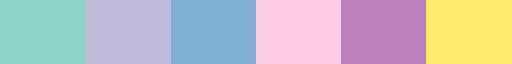

In [4]:
interaction_cm

# Data loading

## Kinodata 3D with dunbrack states

In [5]:
kinodata3d = get_kinodata3d_source_df().rename(
    columns={"activity_id": COLS.ACTIVITY_ID}
)
kinodata3d.head(3)

,activities.activity_id,activities.standard_value,dunbrack_simplified,abreviated_dunbrack_state,UniprotID,similar.klifs_structure_id,compound_structures.canonical_smiles,dfg_state,dunbrack_conf,dunbrack_active,docking.predicted_rmsd
0,32335,5.148742,Inactive_DFGout_BBAminus,Inactive_DFGout_BBAminus_SBin_None_CTout,P35968,5326,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,DFGout,BBAminus,Inactive,4.720892
1,32336,5.468521,Inactive_DFGout_None,Inactive_DFGout_None_None_NTout_CTout,Q02763,5553,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,DFGout,NaN,Inactive,5.696663
2,32680,5.031517,Inactive_DFGin_BLBplus,Inactive_DFGin_BLBplus_SBout_NTout_CTin,P00533,12838,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,DFGin,BLBplus,Inactive,4.851336


In [6]:
(kinodata3d.groupby([COLS.DUNBRACK_SIMPLIFIED, COLS.UNIPROT_ID]).size() >= 100).sum()

np.int64(216)

## Wheels of fortune: dunbrack state pie plots

Text(0.5, 1.0, 'DFG states')

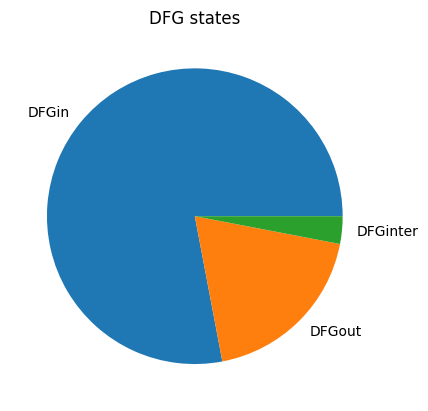

In [7]:
plt.pie(
    x=kinodata3d["dfg_state"].value_counts().values,
    labels=kinodata3d["dfg_state"].value_counts().index,
)
plt.title("DFG states")

Text(0.5, 1.0, 'Dunbrack conformations')

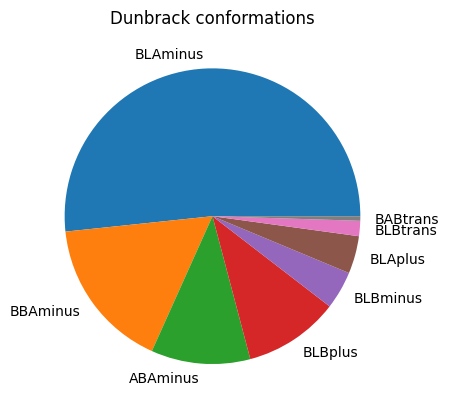

In [8]:
plt.pie(
    x=kinodata3d[COLS.DUNBRACK_CONF].value_counts().values,
    labels=kinodata3d[COLS.DUNBRACK_CONF].value_counts().index,
)
plt.title("Dunbrack conformations")

Text(0.5, 1.0, 'Dunbrack active states')

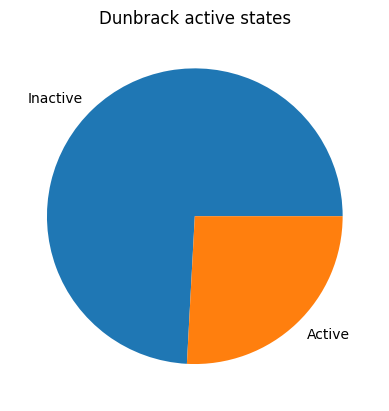

In [9]:
plt.pie(
    x=kinodata3d[COLS.DUNBRACK_ACTIVE].value_counts().values,
    labels=kinodata3d[COLS.DUNBRACK_ACTIVE].value_counts().index,
)
plt.title("Dunbrack active states")

Text(0.5, 1.0, 'Simplified Dunbrack states')

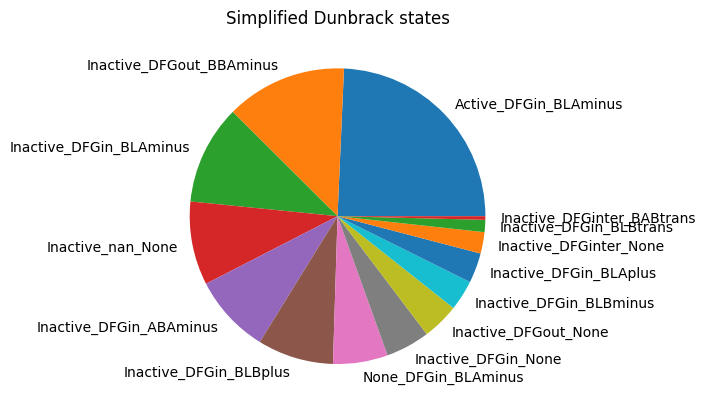

In [10]:
plt.pie(
    x=kinodata3d[COLS.DUNBRACK_SIMPLIFIED].value_counts().values,
    labels=kinodata3d[COLS.DUNBRACK_SIMPLIFIED].value_counts().index,
)
plt.title("Simplified Dunbrack states")

### No large difference in activity over dunbrack states

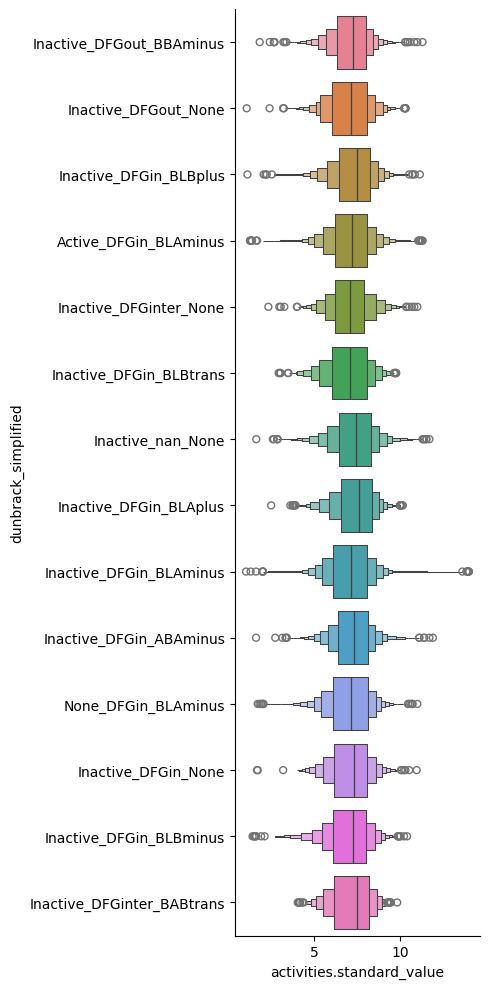

In [11]:
sns.catplot(
    kinodata3d,
    y=COLS.DUNBRACK_SIMPLIFIED,
    x="activities.standard_value",
    hue=COLS.DUNBRACK_SIMPLIFIED,
    height=10,
    aspect=0.5,
    orient="h",
    kind="boxen",
)

In [12]:
def kth_largest(x: np.ndarray, k=0) -> np.ndarray:
    """
    Return the k-th largest element in x.
    """
    if len(x) == 0:
        return np.nan
    if k >= len(x):
        return np.nan
    return np.sort(x)[-k - 1]


dunbrack_fractions = (
    kinodata3d.groupby(COLS.UNIPROT_ID)[COLS.DUNBRACK_SIMPLIFIED]
    .value_counts()
    .reset_index()
    .groupby(COLS.UNIPROT_ID)["count"]
    .apply(lambda x: x / x.sum())
    .reset_index(name="fraction")
)

In [13]:
test_array = np.random.rand(10)
(
    test_array,
    kth_largest(test_array, 0),
    kth_largest(test_array, 1),
    kth_largest(test_array, 2),
)

(array([0.28765308, 0.61452674, 0.94809033, 0.42943755, 0.38791945,
        0.6646882 , 0.11742515, 0.00506592, 0.04165461, 0.21762503]),
 np.float64(0.9480903345083886),
 np.float64(0.6646882048734605),
 np.float64(0.6145267401574562))

In [14]:
num_distinct_dunbrack_states = (
    kinodata3d.groupby(COLS.UNIPROT_ID)[COLS.DUNBRACK_SIMPLIFIED]
    .value_counts()
    .reset_index(name="count")
    .query("count >= 100")
    .groupby(COLS.UNIPROT_ID)[COLS.DUNBRACK_SIMPLIFIED]
    .nunique()
    .reset_index()
)
num_distinct_dunbrack_states.rename(
    columns={COLS.DUNBRACK_SIMPLIFIED: "num_dunbrack_states"}, inplace=True
)
num_distinct_dunbrack_states

,UniprotID,num_dunbrack_states
0,O00141,1
1,O00329,2
2,O00444,1
3,O14757,1
4,O14965,8
...,...,...
116,Q9P1W9,1
117,Q9UBF8,1
118,Q9UHD2,1
119,Q9UM73,1


Text(0, 0.5, 'Number of data points in kinodata-3D')

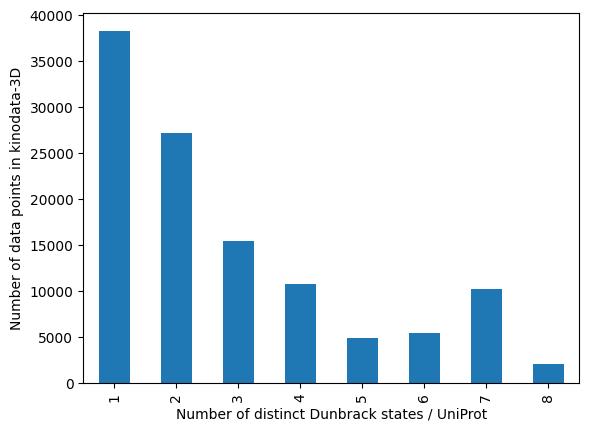

In [15]:
kinodata3d.merge(num_distinct_dunbrack_states).groupby("num_dunbrack_states").agg(
    "size"
).plot.bar()
plt.xlabel("Number of distinct Dunbrack states / UniProt")
plt.ylabel("Number of data points in kinodata-3D")

## Load PLIP interaction data frames

In [16]:
activity_id_and_klifs_id = kinodata3d[[COLS.ACTIVITY_ID, COLS.KLIFS_ID]]
resnr_offsets = pd.read_csv(processed_path / "pocket_residues_offset.csv")
K1 = set(resnr_offsets[COLS.KLIFS_ID].unique())


def load_interaction_data(file_name: str, intr_type: str):
    interaction_data = pd.read_csv(plip_path / file_name)
    interaction_data = interaction_data.rename(
        columns={"activity_id": COLS.ACTIVITY_ID}
    )
    interaction_data = interaction_data.merge(
        activity_id_and_klifs_id, on="activities.activity_id"
    )
    # assert interaction_data.shape[0] == N, f"{N} != {interaction_data.shape[0]}"
    N = interaction_data.shape[0]

    K2 = set(interaction_data[COLS.KLIFS_ID].unique())
    if len(diff := K2.difference(K1)) > 0:
        print(f"KLIFS IDs in {file_name} but not in kinodata3d: {diff}")

    interaction_data = interaction_data.merge(
        resnr_offsets[[COLS.KLIFS_ID, "offset", "position"]],
        left_on=[COLS.KLIFS_ID, "RESNR"],
        right_on=[COLS.KLIFS_ID, "position"],
        how="left",
    )
    interaction_data = interaction_data.drop_duplicates()
    assert interaction_data.shape[0] == N
    interaction_data.dropna(subset=["offset"], inplace=True)
    interaction_data["offset"] = interaction_data["offset"].astype(int)
    interaction_data["RESNR"] = interaction_data["RESNR"] + interaction_data["offset"]
    if interaction_data["RESNR"].isna().any():
        print("NAH!")
        return interaction_data
    interaction_data["residue_region"] = interaction_data["RESNR"].apply(
        lambda x: residue_number_to_region.get(x, "other")
    )
    interaction_data["ITR_TYPE"] = intr_type
    interaction_data["RESNR"] = interaction_data["RESNR"].astype(int)
    return interaction_data


hbonds = load_interaction_data("hydrogen_bonds.csv", "HBOND")
prot_donor_hbonds = hbonds[hbonds["PROTISDON"]]
prot_donor_hbonds["ITR_TYPE"] = "HBOND-D"
prot_acceptor_hbonds = hbonds[~hbonds["PROTISDON"]]
prot_acceptor_hbonds["ITR_TYPE"] = "HBOND-A"
hydrophobic_interactions = load_interaction_data(
    "hydrophobic_interactions.csv", "HYDRO"
)
pi_stacking = load_interaction_data("pi_stacking.csv", "PI_STACK")
salt_bridges = load_interaction_data("salt_bridges.csv", "SALT_BRIDGE")
pi_cation_interactions = load_interaction_data(
    "pi_cation_interactions.csv", "PI_CATION"
)
# halogen_bonds = load_interaction_data("halogen_bonds.csv", "HALOGEN_BOND")

KLIFS IDs in hydrogen_bonds.csv but not in kinodata3d: {np.int64(15056), np.int64(15185), np.int64(15184)}


/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_71853/2062898311.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prot_donor_hbonds["ITR_TYPE"] = "HBOND-D"
/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_71853/2062898311.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prot_acceptor_hbonds["ITR_TYPE"] = "HBOND-A"


KLIFS IDs in hydrophobic_interactions.csv but not in kinodata3d: {np.int64(15056), np.int64(15185), np.int64(15184)}
KLIFS IDs in pi_stacking.csv but not in kinodata3d: {np.int64(15184), np.int64(15185)}
KLIFS IDs in salt_bridges.csv but not in kinodata3d: {np.int64(15056)}
KLIFS IDs in pi_cation_interactions.csv but not in kinodata3d: {np.int64(15184)}


## Data analysis

### Relative frequency of each interaction type

In [17]:
sizes_interaction_types = dict()
for df, name in zip(
    [
        hydrophobic_interactions,
        prot_acceptor_hbonds,
        prot_donor_hbonds,
        pi_stacking,
        salt_bridges,
        # halogen_bonds,
        pi_cation_interactions,
    ],
    [
        "Hydrophobic Intr.",
        "H-Bonds (PA)",
        "H-Bonds (PD)",
        "Pi-Stacking",
        "Salt Bridges",
        # "Halogen Bonds",
        "Pi-Cation Intr.",
    ],
):
    sizes_interaction_types[name] = df.shape[0]

sizes_interaction_types = pd.Series(sizes_interaction_types).sort_index()
sizes_interaction_types

H-Bonds (PA)         131653
H-Bonds (PD)         190428
Hydrophobic Intr.    670041
Pi-Cation Intr.       12168
Pi-Stacking           19883
Salt Bridges          16724
dtype: int64

### Make a dataframe that contains all interactions, dropping interaction specifics such as distance etc.

In [18]:
SHARED_COLS = ["RESNR", "residue_region", "activities.activity_id"]
all_intr = []
for df, name in zip(
    [
        hydrophobic_interactions,
        prot_acceptor_hbonds,
        prot_donor_hbonds,
        pi_stacking,
        salt_bridges,
        # halogen_bonds,
        pi_cation_interactions,
    ],
    [
        "Hydrophobic Intr.",
        "H-Bonds (PA)",
        "H-Bonds (PD)",
        "Pi-Stacking",
        "Salt Bridges",
        # "Halogen Bonds",
        "Pi-Cation Intr.",
    ],
):
    _df = copy.deepcopy(df[SHARED_COLS])
    _df["interaction_type"] = name
    all_intr.append(_df)
all_intr = pd.concat(all_intr)
all_intr["RESNR"] = all_intr["RESNR"].astype(int)
all_intr.head()

,RESNR,residue_region,activities.activity_id,interaction_type
0,3,other,23227035,Hydrophobic Intr.
1,11,other,23227035,Hydrophobic Intr.
2,15,other,23227035,Hydrophobic Intr.
3,36,other,23227035,Hydrophobic Intr.
4,47,Hinge,23227035,Hydrophobic Intr.


#### Coverage of predefined kinase regions 

In [19]:
all_intr.groupby(["residue_region", "interaction_type"]).size().to_frame()

region_sizes = all_intr.groupby(["residue_region", "interaction_type"]).size().unstack()
region_sizes.sum(axis=1)


residue_region
DFG                 102935.0
GK                   60107.0
Hinge               180056.0
SaltBridgeRegion    107661.0
X                    37118.0
other               553020.0
dtype: float64

#### Joint interaction/region plots

In [20]:
coverage_values = (
    region_sizes.reset_index()
    .sort_values("residue_region", ascending=True)
    .fillna(0)
    .values[:, 1:]
).astype(int)
coverage_values


array([[ 14056,  31258,  45408,     66,   6694,   5453],
       [  2940,   2505,  51669,     49,   2944,      0],
       [ 62744,  81570,  34096,     74,   1548,     24],
       [ 14950,  33070,  46560,   9788,      0,   3293],
       [  2104,   2839,  32133,      0,      0,     42],
       [ 34859,  39186, 460175,   2191,   8697,   7912]])

2025-11-04 11:43:51,396 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/joint_coverage.svg ...
2025-11-04 11:43:51,433 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/joint_coverage.pdf ...
2025-11-04 11:43:51,581 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/joint_coverage.png ...


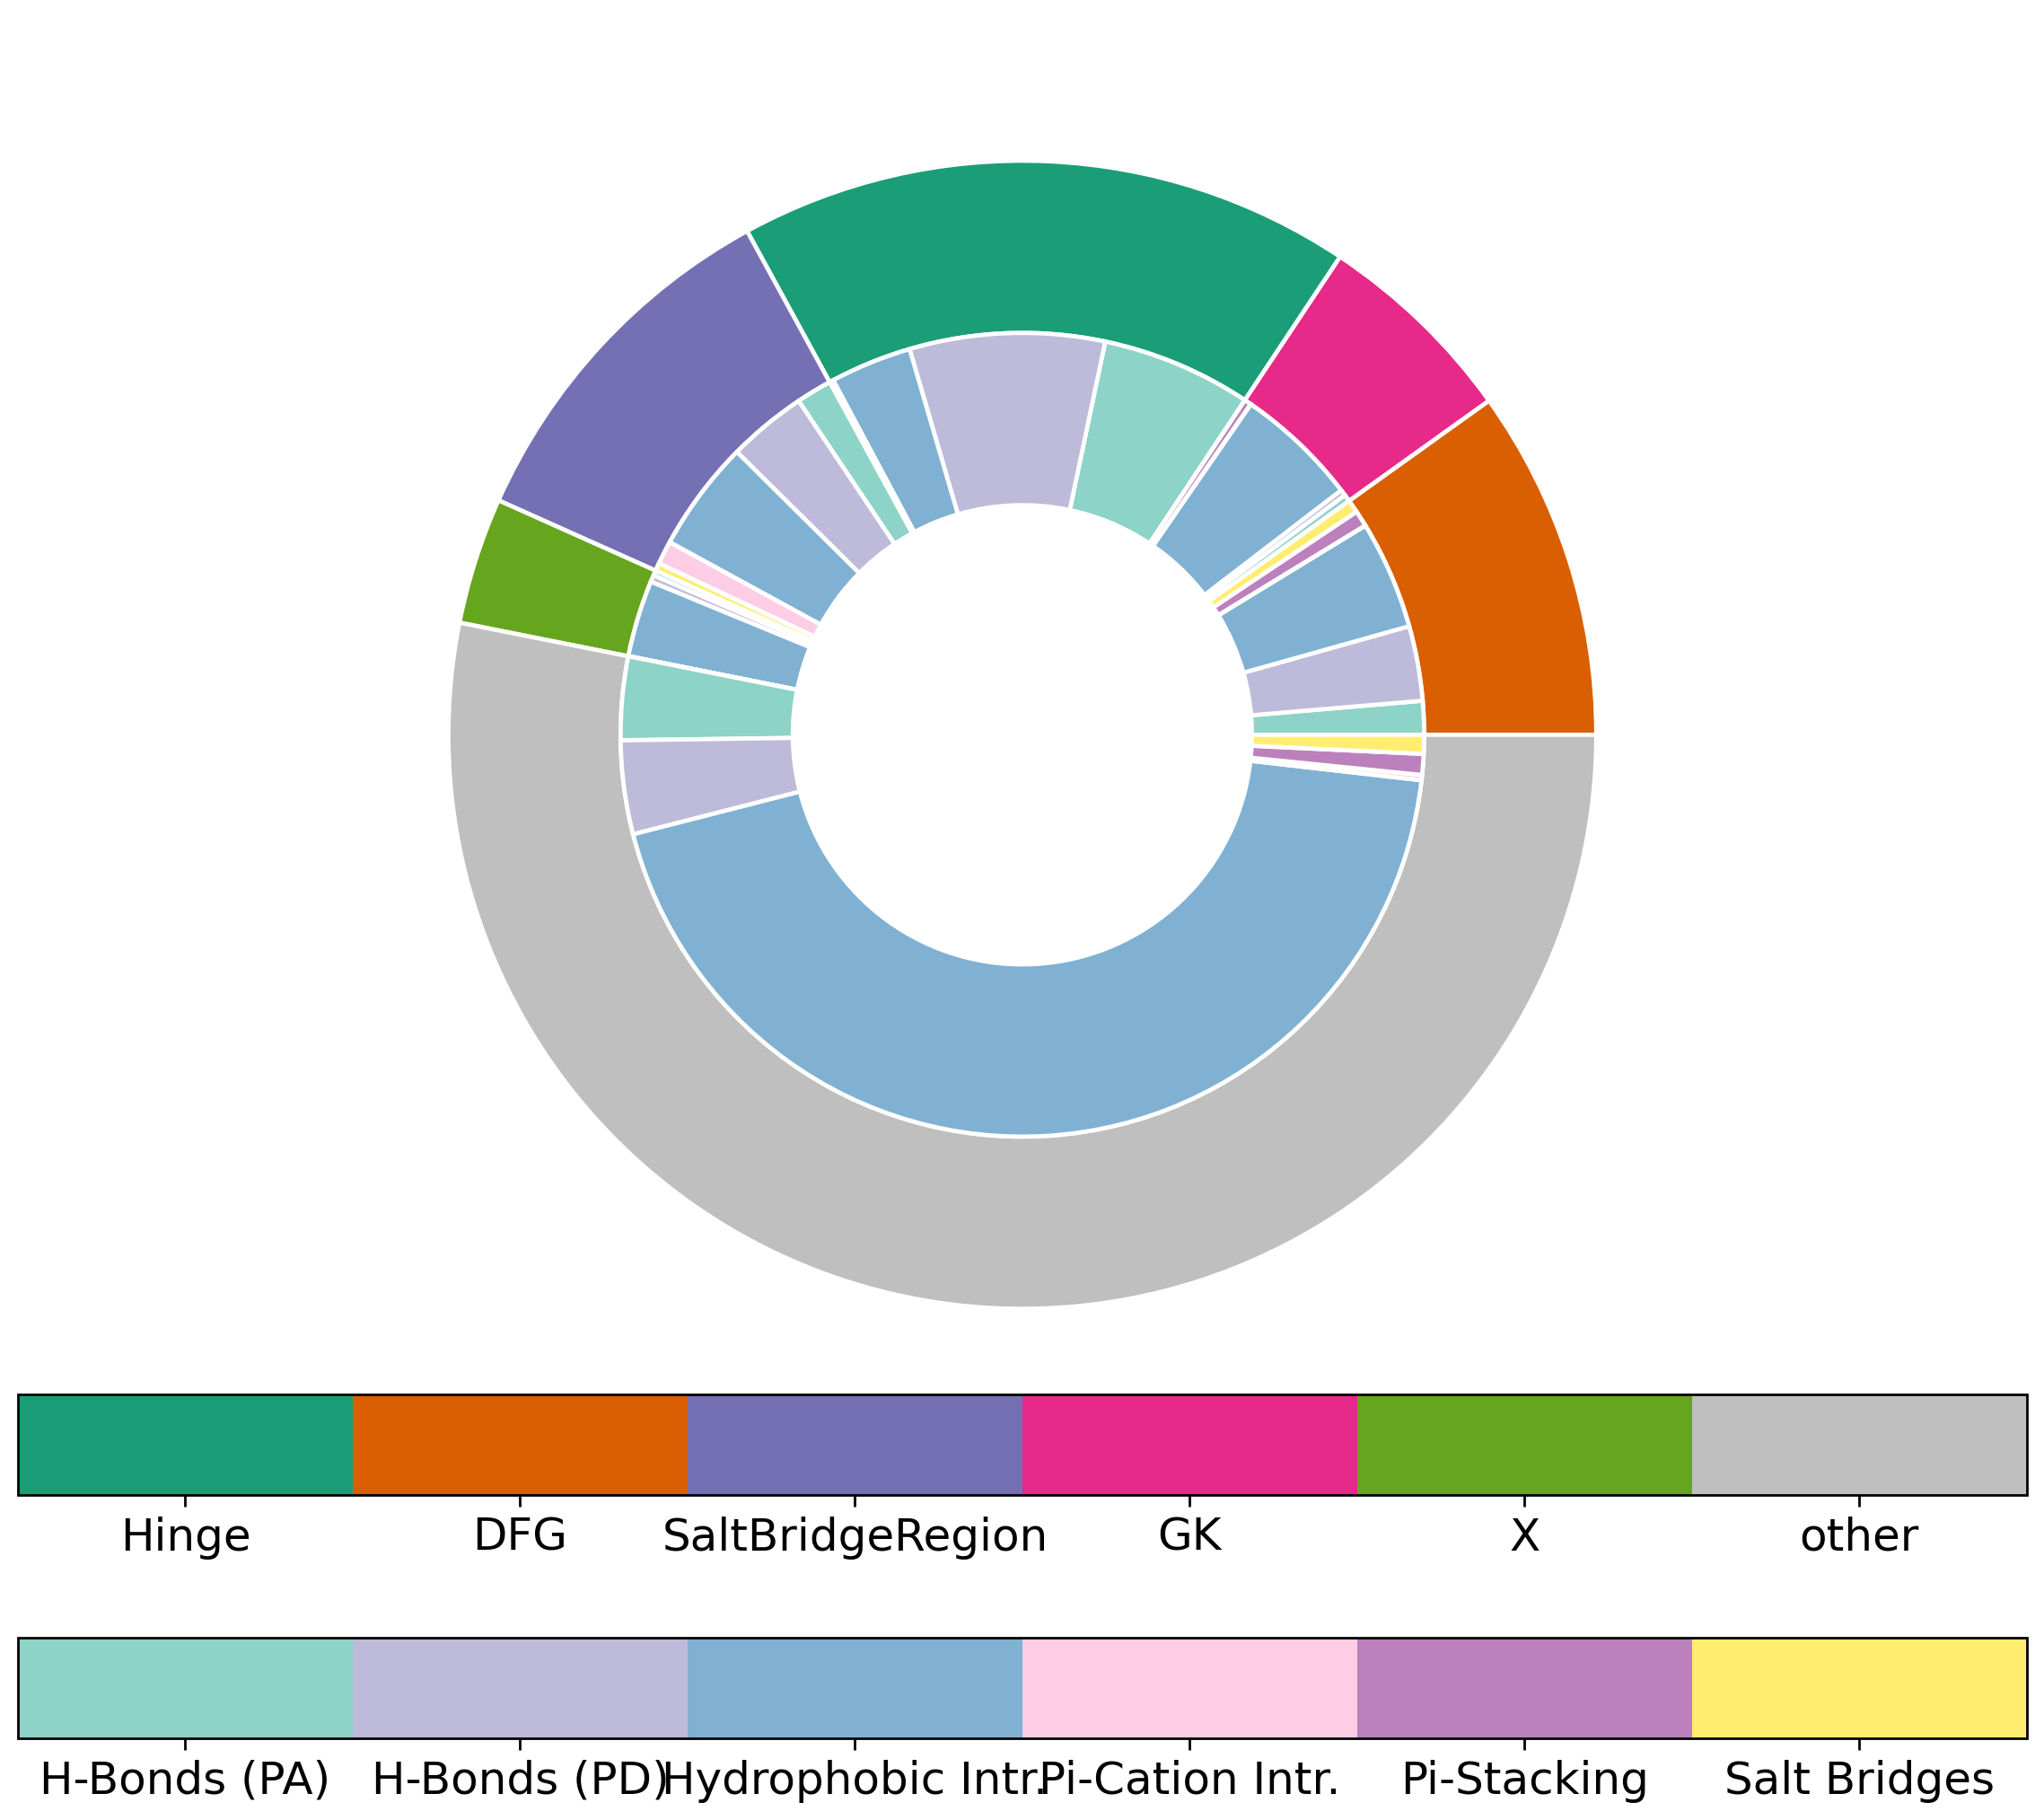

In [21]:
fig, ax = plt.subplots(figsize=(12, 18), dpi=200)
sns.set_context("paper")

size = 0.3

outer_colors = region_colors.sort_index().values
inner_colors = []
for _ in range(6):
    inner_colors.extend(list(interaction_colors))

ax.pie(
    coverage_values.sum(axis=1),
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, linewidth=1.7, edgecolor="w"),
    # labels=region_colors.sort_index().index,
    textprops=dict(fontsize=18),
)

ax.pie(
    coverage_values.flatten(),
    radius=1.0 - size,
    colors=inner_colors,
    wedgeprops=dict(width=size, linewidth=1.7, edgecolor="w"),
)


ITR_TYPES = [
    "H-Bonds (PA)",
    "H-Bonds (PD)",
    # "Halogen Bonds",
    "Hydrophobic Intr.",
    "Pi-Cation Intr.",
    "Pi-Stacking",
    "Salt Bridges",
]

cbar = True
if cbar:
    # Add the first color bar for interaction colors
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=interaction_cm),
        ax=ax,
        orientation="horizontal",
        pad=-0.06,
        shrink=1.4,
    )
    cbar.set_ticks(
        [i / len(ITR_TYPES) + 1 / (2 * len(ITR_TYPES)) for i in range(len(ITR_TYPES))]
    )
    cbar.set_ticklabels(ITR_TYPES, fontsize=18)

    # Add the second color bar for region colors
    region_cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=plt.cm.colors.ListedColormap(region_colors.values)),
        ax=ax,
        orientation="horizontal",
        pad=-0.02,
        shrink=1.4,
    )
    region_cbar.set_ticks(
        [
            i / len(region_colors) + 1 / (2 * len(region_colors))
            for i in range(len(region_colors))
        ]
    )
    region_cbar.set_ticklabels(region_colors.index, fontsize=18)
plt.tight_layout()

write_figure("joint_coverage", dpi=300)

2025-11-04 11:43:51,904 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/interaction_pie_plot.svg ...
2025-11-04 11:43:51,922 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/interaction_pie_plot.pdf ...
2025-11-04 11:43:51,944 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/interaction_pie_plot.png ...


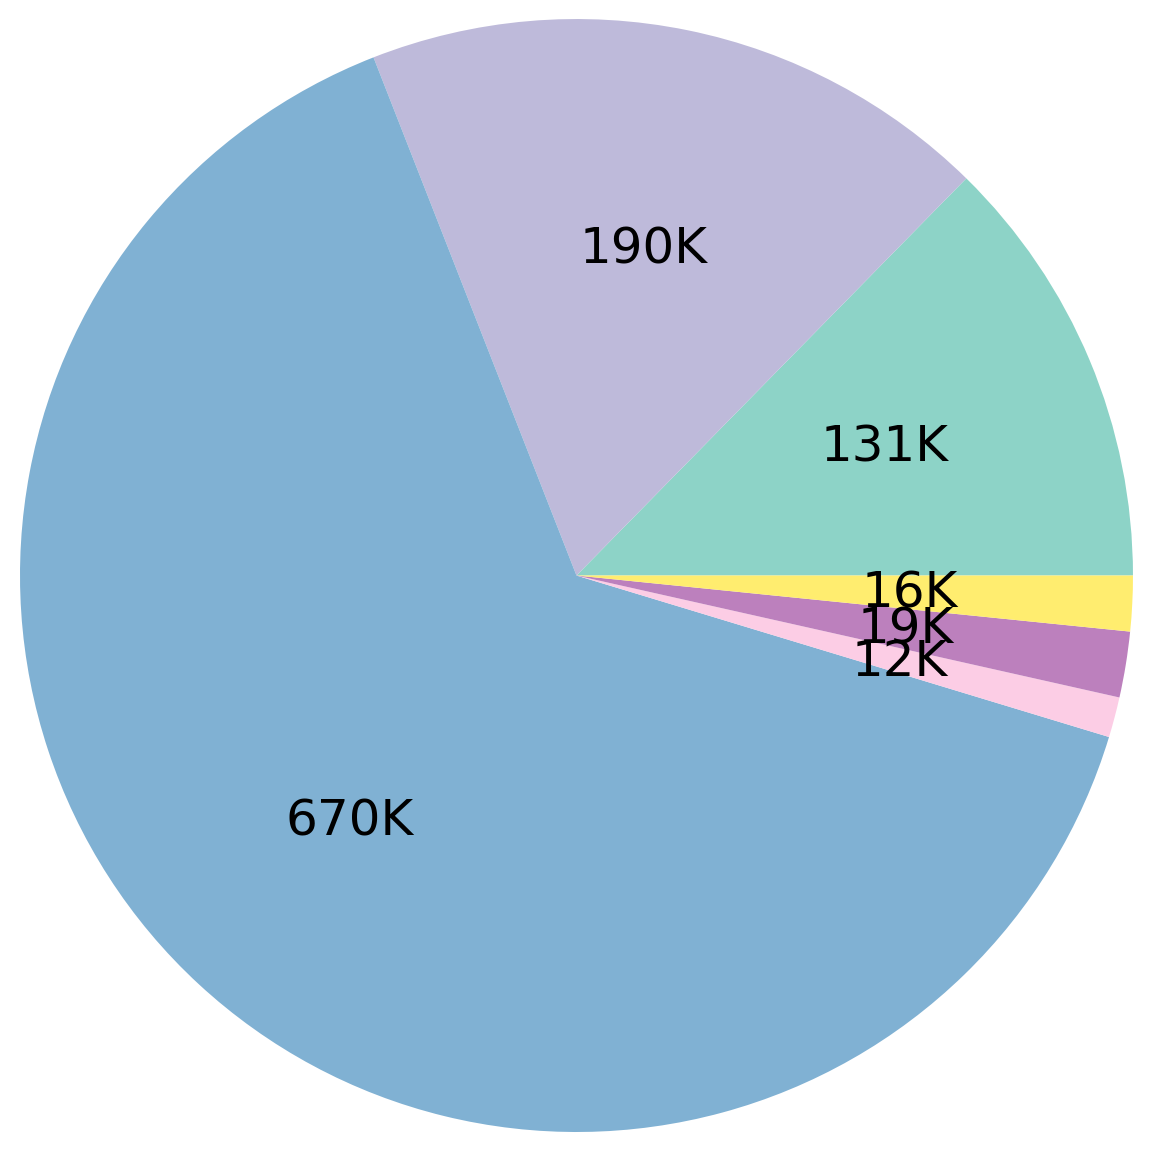

In [22]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=200)
ax.set_aspect("equal")
sns.set_context("paper")


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        thousands = val // 1000
        return "{v:d}K".format(v=thousands)

    return my_format


wedges, texts, autotexts = plt.pie(
    sizes_interaction_types,
    # labels=sizes_interaction_types.index,
    autopct=autopct_format(sizes_interaction_types),
    colors=interaction_colors,
    radius=2,
    textprops=dict(fontsize=18),
)
# make the number label of hydrpgen bonds white for better visibility
# autotexts[0].set_color("white")

plt.tight_layout()
write_figure(
    "interaction_pie_plot",
)

2025-11-04 11:43:52,211 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/kinase_region_pie_plot.svg ...
2025-11-04 11:43:52,221 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/kinase_region_pie_plot.pdf ...
2025-11-04 11:43:52,239 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/kinase_region_pie_plot.png ...


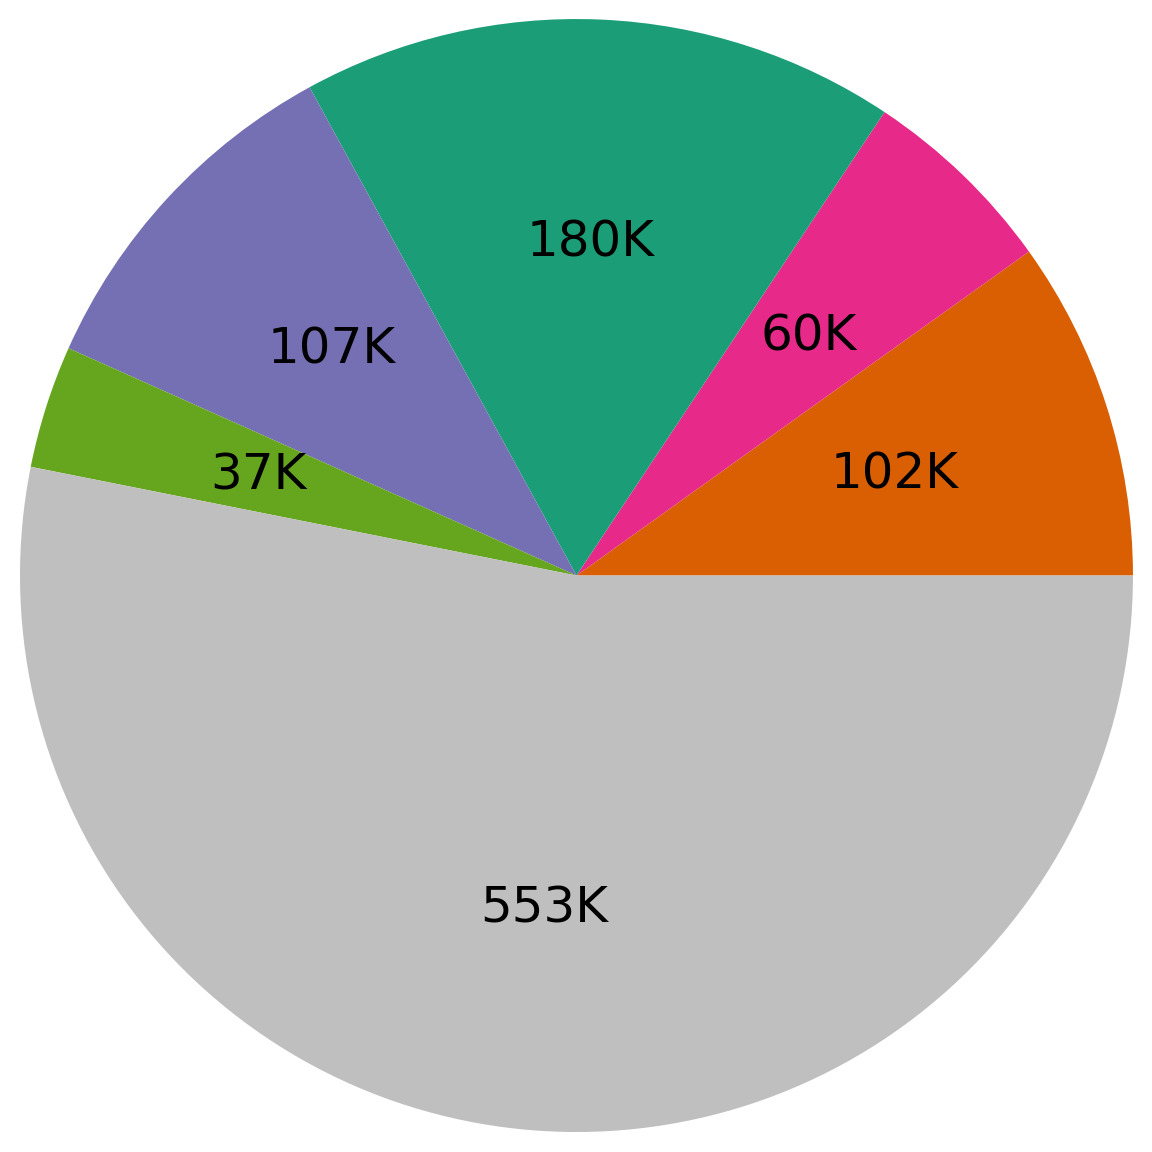

In [23]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=200)
ax.set_aspect("equal")
sns.set_context("paper")
sizes_kinase_regions = dict()
for region in kinase_regions:
    sizes_kinase_regions[region] = all_intr[all_intr["residue_region"] == region].shape[
        0
    ]
sizes_kinase_regions["other"] = all_intr[all_intr["residue_region"] == "other"].shape[0]
sizes_kinase_regions = pd.Series(sizes_kinase_regions).sort_index()
_ = plt.pie(
    sizes_kinase_regions,
    # labels=sizes_kinase_regions.index,
    autopct=autopct_format(sizes_kinase_regions),
    colors=region_colors.sort_index().values,
    radius=2,
    textprops={"fontsize": 18},
)
plt.tight_layout()
write_figure(
    "kinase_region_pie_plot",
)

In [24]:
import matplotlib.pyplot as plt


RESIDUE_COLORS = [residue_colors[resnr - 1] for resnr in range(1, 86)]


def add_kinase_coloring(ax, draw_legend, fontsize=18):
    # color xticks based on residue number region
    for label in ax.get_xticklabels():
        resnr = int(label.get_text())
        region = residue_number_to_region.get(resnr, "other")
        index = (list(kinase_regions.keys()) + ["other"]).index(region)
        label.set_color(region_colors.iloc[index])

    if draw_legend:
        # add a legend that maps region to color
        legend_elements = [
            plt.Line2D([0], [0], color=region_colors.iloc[i], lw=4, label=region)
            for i, region in enumerate(list(kinase_regions.keys()) + ["other"])
        ]
        ax.legend(handles=legend_elements, title="Residue region", fontsize=fontsize)


def plot_interaction_distribution(
    df, title, ax=None, draw_legend: bool = False, fontsize=18, set_xlabel: bool = False
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 5))
    (
        df["RESNR"]
        .value_counts()
        .sort_index()
        .reindex(range(1, 86), fill_value=0)
        .plot.bar(ax=ax, color=RESIDUE_COLORS, fontsize=fontsize)
    )
    ax.set_xlabel("")
    if set_xlabel:
        ax.set_xlabel("KLIFS residue number", fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    add_kinase_coloring(ax, draw_legend, fontsize)

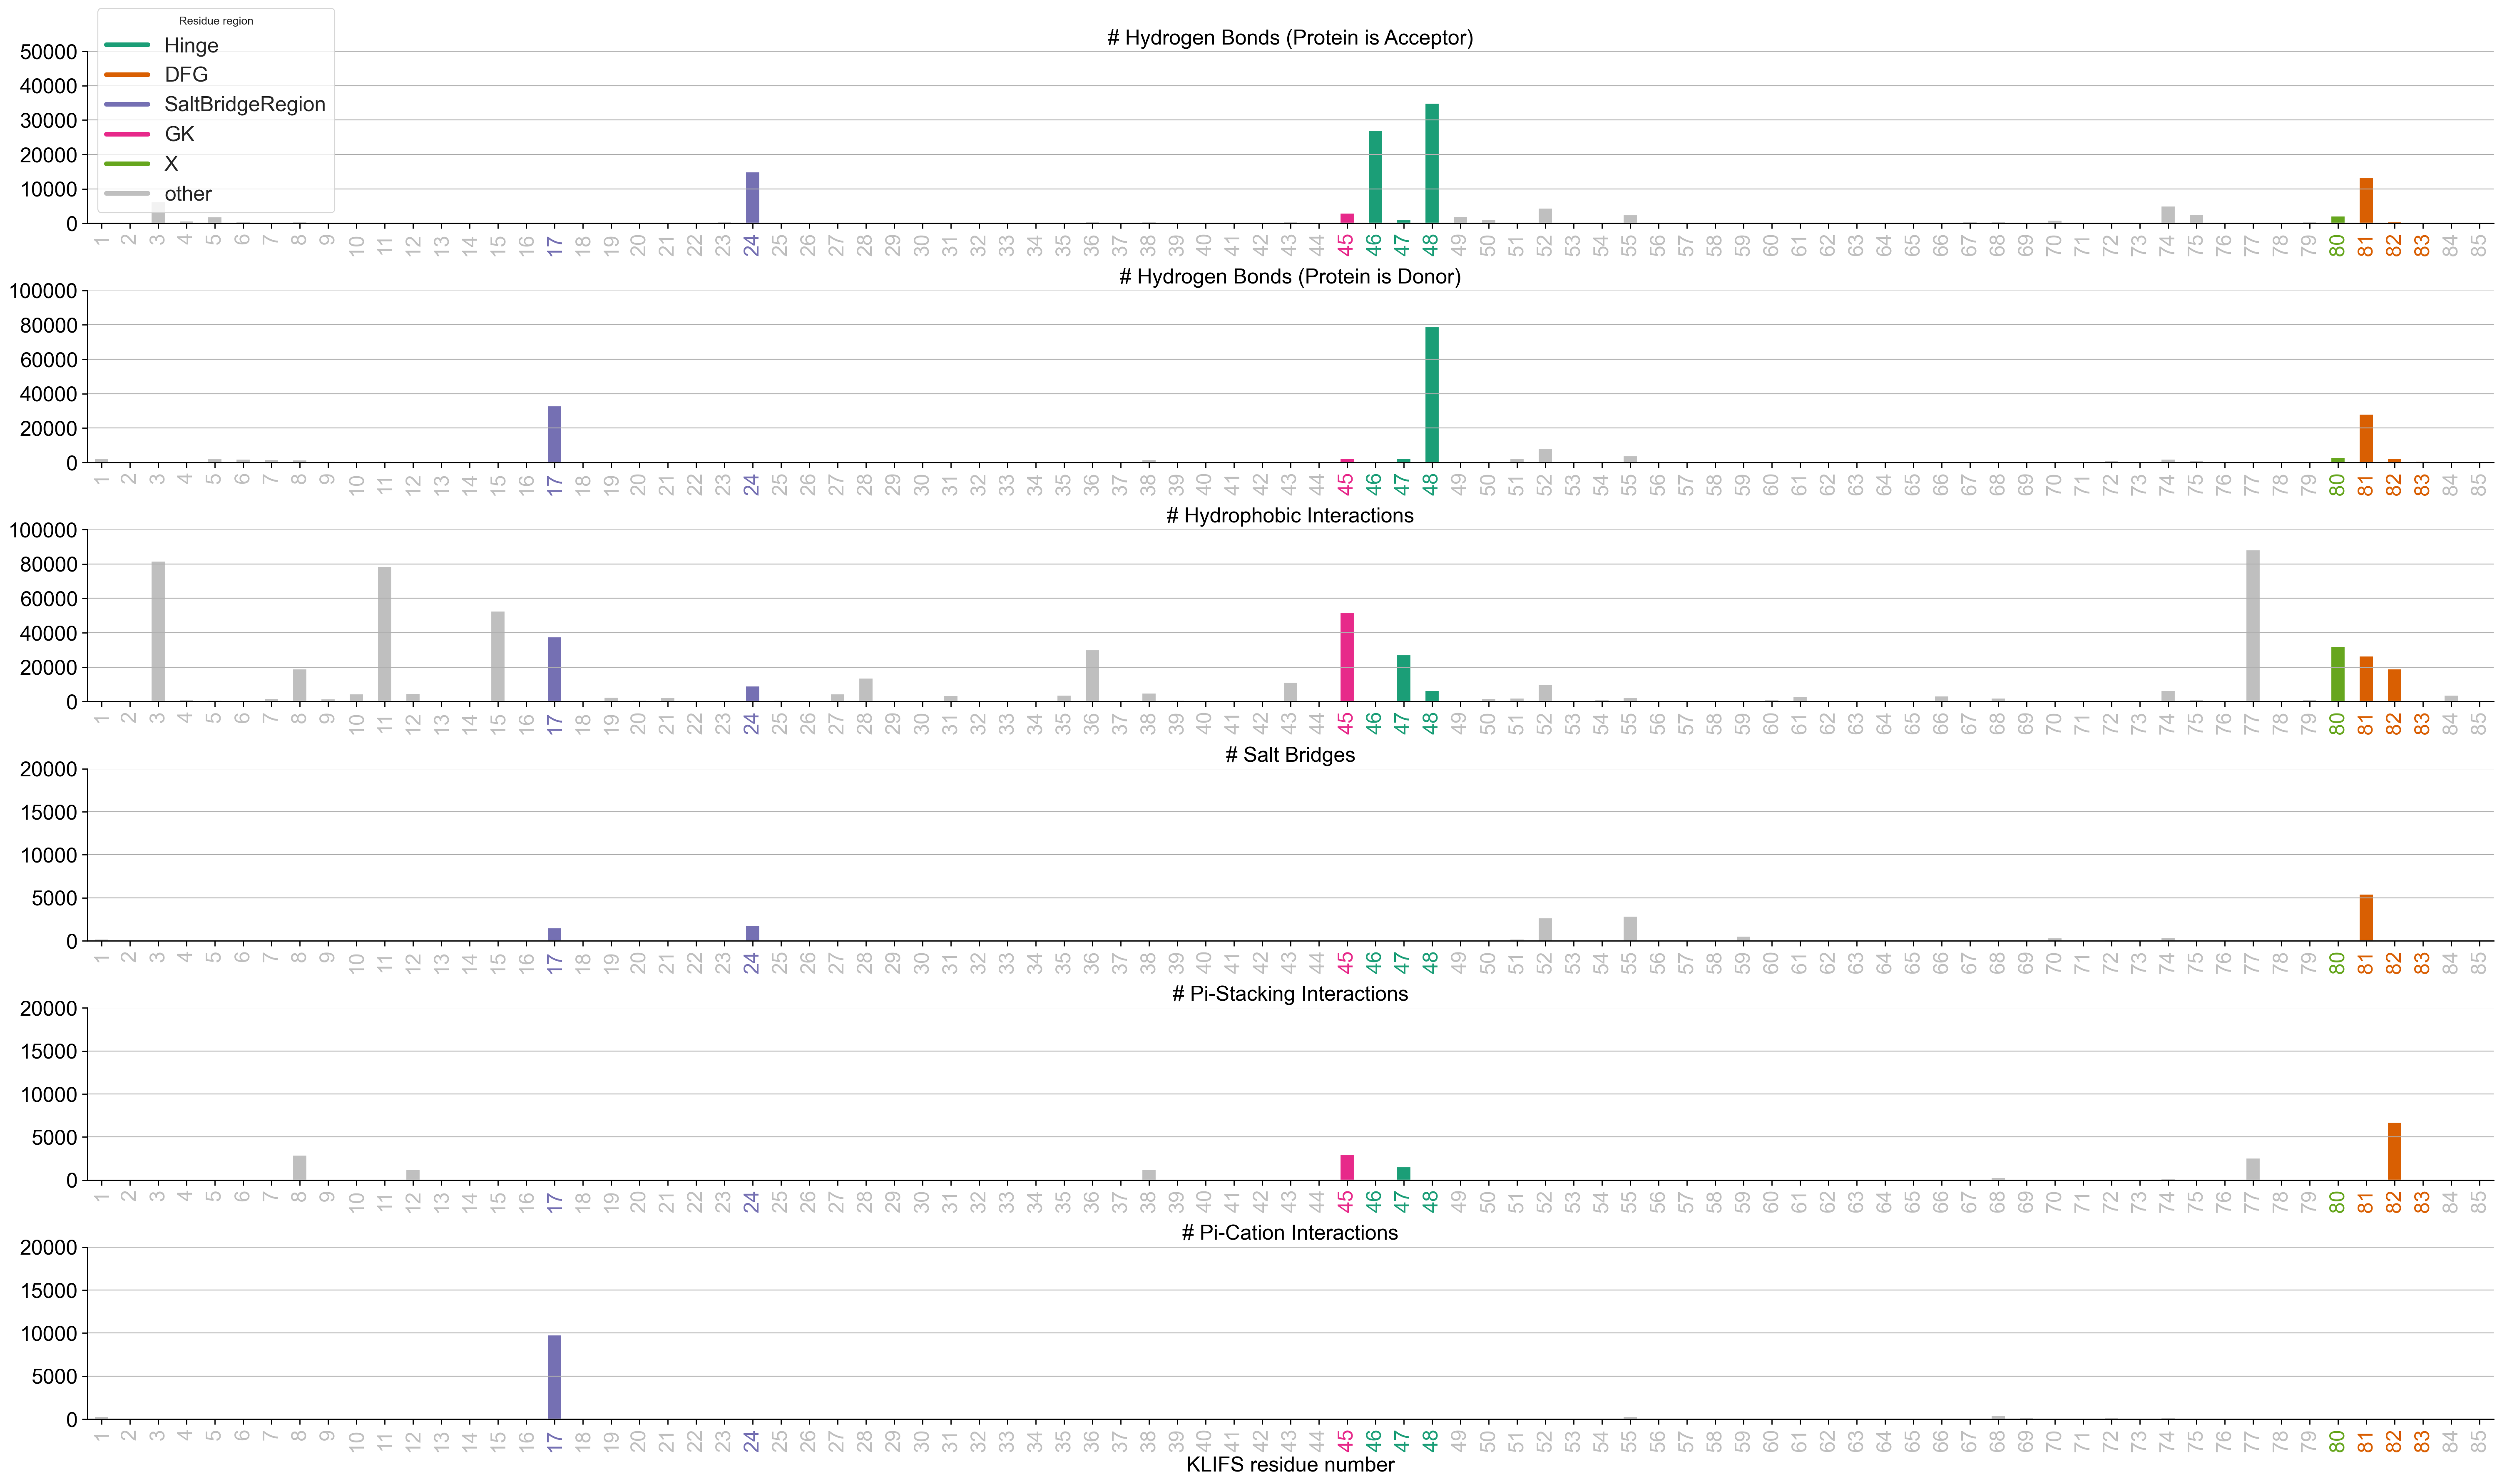

In [25]:
fig, ax = plt.subplots(6, 1, figsize=(30, 18), dpi=200)
sns.set_style("whitegrid")
plot_interaction_distribution(
    prot_acceptor_hbonds,
    "# Hydrogen Bonds (Protein is Acceptor)",
    ax=ax[0],
    draw_legend=True,
)
plot_interaction_distribution(
    prot_donor_hbonds,
    "# Hydrogen Bonds (Protein is Donor)",
    ax=ax[1],
    draw_legend=False,
)
plot_interaction_distribution(
    hydrophobic_interactions, "# Hydrophobic Interactions", ax=ax[2]
)
plot_interaction_distribution(salt_bridges, "# Salt Bridges", ax=ax[3])
# plot_interaction_distribution(halogen_bonds, "# Halogen Bonds", ax=ax[3])
plot_interaction_distribution(pi_stacking, "# Pi-Stacking Interactions", ax=ax[4])
plot_interaction_distribution(
    pi_cation_interactions, "# Pi-Cation Interactions", ax=ax[5], set_xlabel=True
)
plt.tight_layout()
# set 4 reasonable y ticks for each axes:
for ax_ in ax:
    ylim_upper = ax_.get_ylim()[1]
    scale_in_thousands = ylim_upper // 1000
    if scale_in_thousands < 25:
        y_max = 20000
        step_size = 5000
    elif scale_in_thousands < 55:
        y_max = 50000
        step_size = 10000
    else:
        y_max = 100000
        step_size = 20000
    y_ticks = np.arange(0, y_max + 1, step_size)
    ax_.set_yticks(y_ticks)
    ax_.set_yticklabels(y_ticks, fontsize=18)
    ax_.xaxis.grid(False)
    ax_.yaxis.grid(True)

sns.despine()

/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_71853/3525170113.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
2025-11-04 11:43:54,240 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/interaction_by_resnr.svg ...
2025-11-04 11:43:54,364 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/interaction_by_resnr.pdf ...
2025-11-04 11:43:54,504 - Writing figure to /Users/joschkagross/projects/kinodata-pli-alignment/data/figures/interaction_by_resnr.png ...


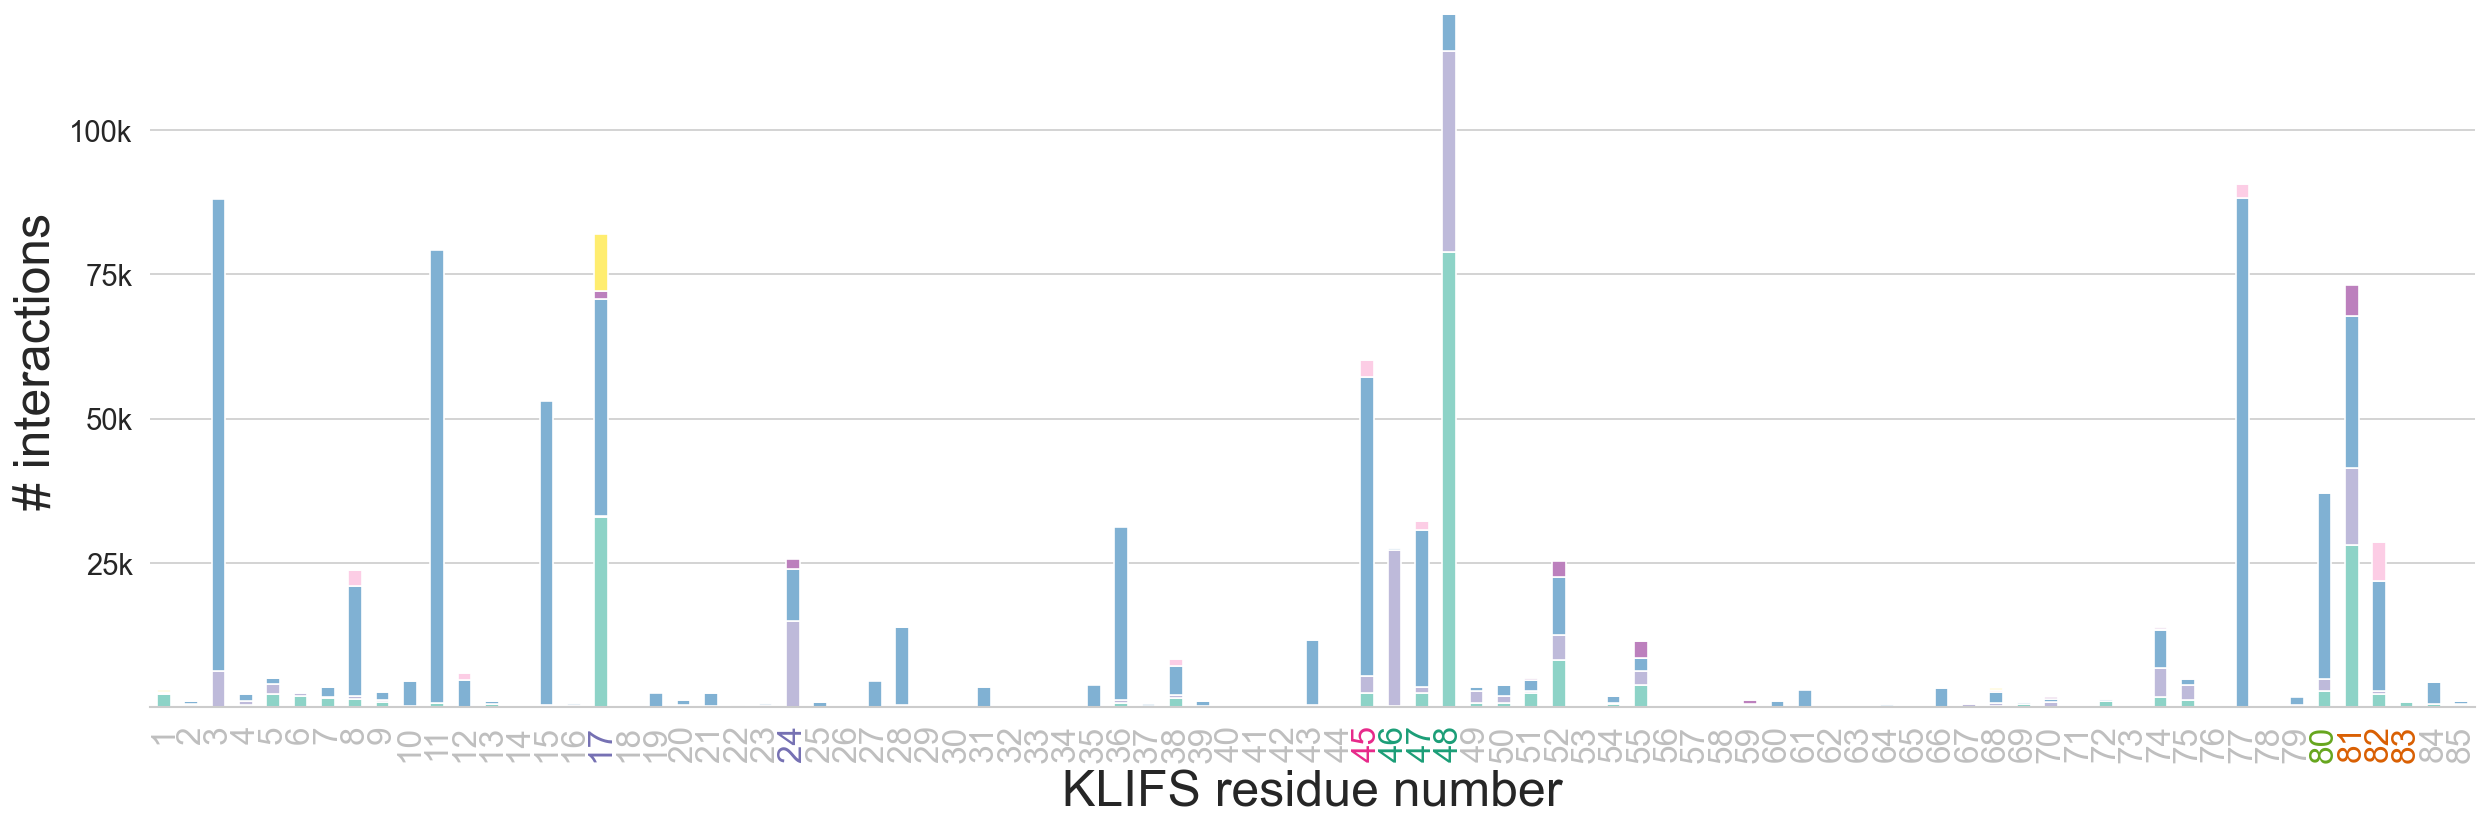

In [26]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=150)
sns.set_style("whitegrid")
# disable vertical grid lines


SHORT_ITR_TYPES = [
    "HBOND-D",
    "HBOND-A",
    "HYDRO",
    "PI_STACK",
    "SALT_BRIDGE",
    # "HALOGEN_BOND",
    "PI_CATION",
]

LONG_ITR_TYPES = [
    "Hydrogen Bonds (D)",
    "Hydrogen Bonds (A)",
    "Hydrophobic Interactions",
    "Pi-Stacking",
    "Salt Bridges",
    # "Halogen Bonds",
    "Pi-Cation Interactions",
]


def to_long_names(df):
    return df.rename(columns=dict(zip(SHORT_ITR_TYPES, LONG_ITR_TYPES)))


SHARED_COLS = [
    "RESNR",
    "RESTYPE",
    COLS.ACTIVITY_ID,
    "ITR_TYPE",
    "similar.klifs_structure_id",
]
all_interactions = pd.concat(
    (
        prot_donor_hbonds[SHARED_COLS],
        prot_acceptor_hbonds[SHARED_COLS],
        hydrophobic_interactions[SHARED_COLS],
        pi_stacking[SHARED_COLS],
        salt_bridges[SHARED_COLS],
        # halogen_bonds[SHARED_COLS],
        pi_cation_interactions[SHARED_COLS],
    )
)
all_interactions = all_interactions.dropna(subset="RESNR")
all_interactions["RESNR"] = all_interactions["RESNR"].astype(int)

all_interactions["ITR_TYPE_INDEX"] = all_interactions["ITR_TYPE"].apply(
    lambda x: SHORT_ITR_TYPES.index(x)
)

all_interactions["const_one"] = 1
all_interactions["ident"] = all_interactions["RESNR"].index
all_interactions_wide = all_interactions.pivot_table(
    index=["ident", "RESNR", COLS.ACTIVITY_ID],
    columns="ITR_TYPE",
    values="const_one",
    fill_value=0,
).reset_index()
to_long_names(all_interactions_wide).groupby("RESNR")[LONG_ITR_TYPES].sum().reindex(
    range(1, 86), fill_value=0
).plot.bar(stacked=True, color=interaction_colors, ax=ax)
ax.set_xticklabels(
    range(1, 86),
    rotation=90,
    fontsize=16,
)
ax.set_yticklabels(
    [f"{int(tick // 1000)}k" for tick in ax.get_yticks()],
    fontsize=14,
)
ax.set_yticks([25 * 1000, 50 * 1000, 75 * 1000, 100 * 1000])
ax.set_yticklabels(["25k", "50k", "75k", "100k"])
# update legend title
plt.legend([], [], frameon=False)
sns.despine(left=True)
ax.set_xlabel("KLIFS residue number", fontsize=24)
ax.set_ylabel("# interactions", fontsize=24)
ax.xaxis.grid(False)
add_kinase_coloring(ax, draw_legend=False)
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1.05, 1.05))
write_figure("interaction_by_resnr")

In [27]:
SHARED_COLS = [
    "RESNR",
    "RESTYPE",
    COLS.ACTIVITY_ID,
    "ITR_TYPE",
    "similar.klifs_structure_id",
]
all_interactions = pd.concat(
    (
        prot_acceptor_hbonds[SHARED_COLS],
        prot_donor_hbonds[SHARED_COLS],
        hydrophobic_interactions[SHARED_COLS],
        pi_stacking[SHARED_COLS],
        salt_bridges[SHARED_COLS],
        # halogen_bonds[SHARED_COLS],
        pi_cation_interactions[SHARED_COLS],
    )
)
all_interactions = all_interactions.dropna(subset="RESNR")
all_interactions["RESNR"] = all_interactions["RESNR"].astype(int)

all_interactions["ITR_TYPE_INDEX"] = all_interactions["ITR_TYPE"].apply(
    lambda x: [
        "HBOND-A",
        "HBOND-D",
        "HYDRO",
        "PI_STACK",
        "SALT_BRIDGE",
        # "HALOGEN_BOND",
        "PI_CATION",
    ].index(x)
)
all_interactions.head(3)


,RESNR,RESTYPE,activities.activity_id,ITR_TYPE,similar.klifs_structure_id,ITR_TYPE_INDEX
0,48,LEU,23227035,HBOND-A,14808,0
4,48,MET,2111945,HBOND-A,2272,0
8,24,GLU,24850809,HBOND-A,1942,0


In [28]:
all_interactions.to_csv(
    DATA_PATH / "processed" / "plip" / "all_interactions.csv",
    index=False,
)